# Programming Assignment: Numerical Optimization for Logistic Regression.

### Name: Aaron Vo


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.01171234  0.10929275 -0.03226254 -0.06173084  0.13106485 -0.10140582
   0.00469117 -0.05288439]]
test std = 
[[1.05659546 1.08986003 1.00555254 0.95816196 1.3219801  0.96537981
  0.95800395 0.94954147]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5938129844109292
Objective value at t=2 is 0.5511615115465683
Objective value at t=3 is 0.5276824280212846
Objective value at t=4 is 0.5128710533995097
Objective value at t=5 is 0.5027895958537987
Objective value at t=6 is 0.495594865486538
Objective value at t=7 is 0.49029063506546183
Objective value at t=8 is 0.4862848281403996
Objective value at t=9 is 0.4832019831427478
Objective value at t=10 is 0.48079271160162534
Objective value at t=11 is 0.4788855026693212
Objective value at t=12 is 0.47735913211565034
Objective value at t=13 is 0.47612597817161856
Objective value at t=14 is 0.4751214994169836
Objective value at t=15 is 0.47429737445479053
Objective value at t=16 is 0.47361690589076605
Objective value at t=17 is 0.47305187006497934
Objective value at t=18 is 0.47258031470602757
Objective value at t=19 is 0.4721849922732256
Objective value at t=20 is 0.47185222804435745
Objective value at t=21 is 0.4715710

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.526912212337405
Objective value at epoch t=1 is 0.517097872252076
Objective value at epoch t=2 is 0.5111619868682185
Objective value at epoch t=3 is 0.5106461634742435
Objective value at epoch t=4 is 0.5070579724091615
Objective value at epoch t=5 is 0.49522852939926104
Objective value at epoch t=6 is 0.496566709746315
Objective value at epoch t=7 is 0.4939087105397276
Objective value at epoch t=8 is 0.4937304340765573
Objective value at epoch t=9 is 0.49176684365650314
Objective value at epoch t=10 is 0.49081446489453145
Objective value at epoch t=11 is 0.4857364218576258
Objective value at epoch t=12 is 0.4853996147242177
Objective value at epoch t=13 is 0.48197535447526707
Objective value at epoch t=14 is 0.4842596632001512
Objective value at epoch t=15 is 0.4829363969657091
Objective value at epoch t=16 is 0.4784522150565363
Objective value at epoch t=17 is 0.4805213322113017
Objective value at epoch t=18 is 0.47921896162036753
Objective value at e

# 4. Compare GD with SGD

Plot objective function values against epochs.

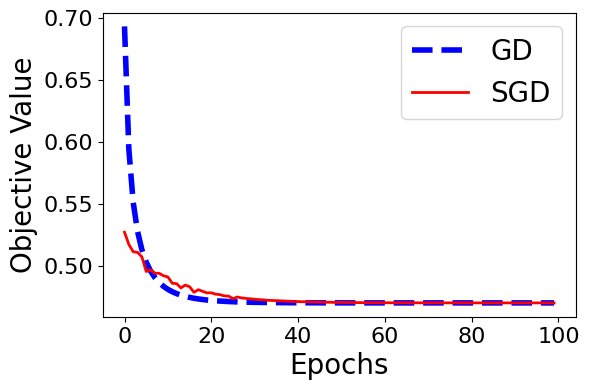

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [21]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [22]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2234375


In [23]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.203125


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [81]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    # Calculate the predicted values (hypothesis)
    n, d = xi.shape
    yx = numpy.multiply(yi, xi) # n-by-d matrix
    yxw = numpy.dot(yx, w)      # n-by-1 matrix
    
    # calculate objective function Q_i
    loss = numpy.mean( numpy.log( 1 + numpy.exp(-yxw))) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar (regularization term)
    obj = loss + reg # scalar
    
    # calculate mini-batch stochastic gradient dQ_i
    g_loss0 = -yx / (1+ numpy.exp(yxw)) # b-by-d matrix (summation section)
    g_loss = numpy.mean((g_loss0), axis=0).reshape(d,1) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [117]:
import numpy as np

# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    ...
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for epoch in range(max_epoch):
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices]
        y_rand = y[rand_indices]
        
        objval = 0 # accumulate the objective values
        for i in range(0, n, b):
            # Select a mini-batch
            xi = x_rand[i:i + b]
            yi = y_rand[i:i + b]
            
                        
            # Calculate the gradient of the log-likelihood
            obj, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            
            objval += obj
            w -= stepsize * g
    
        stepsize *= 0.9 # decrease step size
        objval /= (n/b)
        objvals[epoch] = objval
        print('Objective value at epoch t=' + str(epoch) + ' is ' + str(objval))
    
    return w, objvals

## 6.3. Run MB-SGD

In [118]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.11 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.5456472370512936
Objective value at epoch t=1 is 0.48628021780049535
Objective value at epoch t=2 is 0.47938209057841397
Objective value at epoch t=3 is 0.47635481428387827
Objective value at epoch t=4 is 0.4761664298654253
Objective value at epoch t=5 is 0.47526188707578465
Objective value at epoch t=6 is 0.4751779510377716
Objective value at epoch t=7 is 0.47401809321931176
Objective value at epoch t=8 is 0.4734928243179649
Objective value at epoch t=9 is 0.47344940181734535
Objective value at epoch t=10 is 0.47320771697135156
Objective value at epoch t=11 is 0.47266083734007075
Objective value at epoch t=12 is 0.4722328181111354
Objective value at epoch t=13 is 0.47237030590503537
Objective value at epoch t=14 is 0.4718060254177904
Objective value at epoch t=15 is 0.4718765296182762
Objective value at epoch t=16 is 0.47176819289980887
Objective value at epoch t=17 is 0.47166505326091723
Objective value at epoch t=18 is 0.47131705061955353
Objective 

In [119]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = .1 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch t=0 is 0.6500055700382501
Objective value at epoch t=1 is 0.5866001908172642
Objective value at epoch t=2 is 0.5543732124574288
Objective value at epoch t=3 is 0.5357448056442485
Objective value at epoch t=4 is 0.5237128297082787
Objective value at epoch t=5 is 0.5150904967699029
Objective value at epoch t=6 is 0.508928784505858
Objective value at epoch t=7 is 0.5042813907917115
Objective value at epoch t=8 is 0.5005314953149307
Objective value at epoch t=9 is 0.49786925744351274
Objective value at epoch t=10 is 0.4956209778304032
Objective value at epoch t=11 is 0.49383184804697733
Objective value at epoch t=12 is 0.4921536158774952
Objective value at epoch t=13 is 0.4908973143255834
Objective value at epoch t=14 is 0.48986969825563575
Objective value at epoch t=15 is 0.488987691674323
Objective value at epoch t=16 is 0.48812419071012
Objective value at epoch t=17 is 0.4875123056012895
Objective value at epoch t=18 is 0.4868893981205523
Objective value at epoc

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

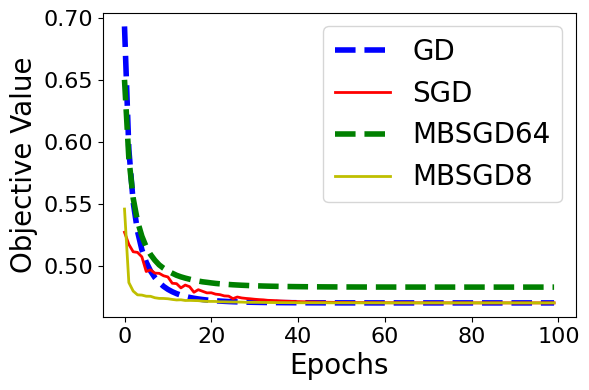

In [120]:
fig = plt.figure(figsize=(6, 4))

epochs_mbsgd64 = range(len(objvals_mbsgd64))
epochs_mbsgd8 = range(len(objvals_mbsgd8))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', linewidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', linewidth=2)
line2, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '--g', linewidth=4)
line3, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-y', linewidth=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MBSGD64', 'MBSGD8'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)